In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pyproj
import matplotlib.pyplot as plt

In [3]:
scorecard = pd.read_csv("Most-Recent-Cohorts-Institution.csv")

/var/folders/d5/fgntt_0n0bz2jjjxck1hczkh0000gn/T/ipykernel_1668/3257712598.py:1: DtypeWarning: Columns (9,1407,1408,1431,1432,1532,1537,1538,1539,1540,1542,1546,1589,1601,1602,1606,1608,1611,1614,1615,1616,1619,1620,1621,1622,1623,1624,1625,1626,1627,1628,1629,1653,1679,1690,1692,1697,1700,1702,1725,1726,1727,1728,1729,1743,1815,1816,1817,1818,1823,1824,1830,1831,1879,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,1890,1891,1892,1893,1894,1895,1896,1897,1898,1909,1910,1911,1912,1913,1957,1958,1959,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1983,1984,2376,2377,2403,2404,2495,2496,2497,2498,2499,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509,2510,2511,2512,2513,2514,2515,2516,2517,2518,2519,2520,2521,2522,2523,2524,2525,2526,2527,2528,2529,2530,2958,3215,3231,3235,3236) have mixed types. Specify dtype option on import or set low_memory=False.
  scorecard = pd.read_csv("Most-Recent-Cohorts-Institution.csv")


In [4]:
needed_cols = ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'ZIP', 'PREDDEG', 'LOCALE', 'LATITUDE', 'LONGITUDE', 'ADM_RATE', 'CONTROL',
               'UGDS_WHITE', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_ASIAN', 'UGDS_AIAN', 'UGDS_NHPI', 
               'PCTPELL', 
               'DEP_INC_PCT_LO', 'DEP_INC_PCT_M1', 'DEP_INC_PCT_M2', 'DEP_INC_PCT_H1', 'DEP_INC_PCT_H2',
               'MDEARN_ALL', 'C150_L4', 'C150_4', 'NPT4_PUB', 'NPT4_PRIV']
scorecard = scorecard[needed_cols]
scorecard.columns = ['id', 'school_name', 'city', 'state', 'zipcode', 'predom_degree_awarded', 'locale', 'latitude', 'longitude', 'admit_rate', 'control',
                     'prop_white', 'prop_black', 'prop_hispanic', 'prop_asian', 'prop_aian', 'prop_nhpi',
                     'pell_grant_rate',
                     'pct_lowinc', 'pct_lowmedinc', 'pct_medinc', 'pct_lowhighinc', 'pct_highinc',
                     'median_earnings', 'cc_completion_rate', '4yr_completion_rate', 'net_price_pub', 'net_price_priv']

In [5]:
# drop rows with no location data
scorecard = scorecard.dropna(subset=['latitude', 'longitude'])

# categorize each institution as either broad-access or not
scorecard['is_broad_access'] = (scorecard['admit_rate'] >= 0.75) | (scorecard['admit_rate'].isna())

# filter for community colleges and 4-year universities
scorecard = scorecard[(scorecard['predom_degree_awarded'] == 2) | (scorecard['predom_degree_awarded'] == 3)]

# filter for public and private non-profits
scorecard = scorecard[(scorecard['control'] == 1) | (scorecard['control'] == 2)]

# drop rows in the U.S. territories
scorecard = scorecard[~scorecard['state'].isin(['AS', 'GU', 'MP', 'PR', 'FM', 'PW', 'VI', 'MH'])]

scorecard

,id,school_name,city,state,zipcode,predom_degree_awarded,locale,latitude,longitude,admit_rate,...,pct_lowmedinc,pct_medinc,pct_lowhighinc,pct_highinc,median_earnings,cc_completion_rate,4yr_completion_rate,net_price_pub,net_price_priv,is_broad_access
0,100654,Alabama A & M University,Normal,AL,35762,3,12.0,34.783368,-86.568502,0.6622,...,0.2034134448,PS,PS,PS,40669,NaN,0.2874,14559.0,NaN,False
1,100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3,12.0,33.505697,-86.799345,0.8842,...,0.1699615596,0.1537616694,0.142778693,0.1847885777,40669,NaN,0.6260,17727.0,NaN,True
2,100690,Amridge University,Montgomery,AL,36117-3553,3,12.0,32.362609,-86.174010,NaN,...,PS,PS,PS,PS,40669,NaN,0.4000,NaN,NaN,True
3,100706,University of Alabama in Huntsville,Huntsville,AL,35899,3,12.0,34.724557,-86.640449,0.7425,...,0.1448545861,0.1605145414,0.1817673378,0.2438478747,40669,NaN,0.6191,19880.0,NaN,False
4,100724,Alabama State University,Montgomery,AL,36104-0271,3,12.0,32.364317,-86.295677,0.9564,...,PS,PS,PS,PS,40669,NaN,0.3018,13889.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,498562,Commonwealth University of Pennsylvania,Bloomsburg,PA,17815,3,32.0,41.007820,-76.447844,0.9475,...,0.1327112494,0.1695178849,PS,PS,40669,NaN,0.5302,18877.0,NaN,True
5870,498571,Pennsylvania Western University,California,PA,15419,3,32.0,40.064964,-79.886790,0.9365,...,0.1449932034,0.1921159946,0.1984594472,0.2075215224,40669,NaN,0.5103,19352.0,NaN,True
5879,498809,Yeshiva of Kasho,Brooklyn,NY,11231-3819,3,11.0,40.671255,-74.000150,NaN,...,NaN,NaN,NaN,NaN,40669,NaN,0.1087,NaN,9078.0,True
5889,498906,Yeshivas Sanz Klauzenburg,Brooklyn,NY,11219-3631,3,11.0,40.632725,-73.990129,NaN,...,NaN,NaN,NaN,NaN,40669,NaN,0.2727,NaN,10556.0,True


In [34]:
scorecard.to_csv("data/scorecard.csv")

In [6]:
# convert to a geodataframe
geometry = [Point(xy) for xy in zip(scorecard['longitude'], scorecard['latitude'])]
schools_gdf = gpd.GeoDataFrame(scorecard, geometry=geometry, crs="EPSG:4326")
schools_gdf

,id,school_name,city,state,zipcode,predom_degree_awarded,locale,latitude,longitude,admit_rate,...,pct_medinc,pct_lowhighinc,pct_highinc,median_earnings,cc_completion_rate,4yr_completion_rate,net_price_pub,net_price_priv,is_broad_access,geometry
0,100654,Alabama A & M University,Normal,AL,35762,3,12.0,34.783368,-86.568502,0.6622,...,PS,PS,PS,40669,NaN,0.2874,14559.0,NaN,False,POINT (-86.5685 34.78337)
1,100663,University of Alabama at Birmingham,Birmingham,AL,35294-0110,3,12.0,33.505697,-86.799345,0.8842,...,0.1537616694,0.142778693,0.1847885777,40669,NaN,0.6260,17727.0,NaN,True,POINT (-86.79934 33.5057)
2,100690,Amridge University,Montgomery,AL,36117-3553,3,12.0,32.362609,-86.174010,NaN,...,PS,PS,PS,40669,NaN,0.4000,NaN,NaN,True,POINT (-86.17401 32.36261)
3,100706,University of Alabama in Huntsville,Huntsville,AL,35899,3,12.0,34.724557,-86.640449,0.7425,...,0.1605145414,0.1817673378,0.2438478747,40669,NaN,0.6191,19880.0,NaN,False,POINT (-86.64045 34.72456)
4,100724,Alabama State University,Montgomery,AL,36104-0271,3,12.0,32.364317,-86.295677,0.9564,...,PS,PS,PS,40669,NaN,0.3018,13889.0,NaN,True,POINT (-86.29568 32.36432)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,498562,Commonwealth University of Pennsylvania,Bloomsburg,PA,17815,3,32.0,41.007820,-76.447844,0.9475,...,0.1695178849,PS,PS,40669,NaN,0.5302,18877.0,NaN,True,POINT (-76.44784 41.00782)
5870,498571,Pennsylvania Western University,California,PA,15419,3,32.0,40.064964,-79.886790,0.9365,...,0.1921159946,0.1984594472,0.2075215224,40669,NaN,0.5103,19352.0,NaN,True,POINT (-79.88679 40.06496)
5879,498809,Yeshiva of Kasho,Brooklyn,NY,11231-3819,3,11.0,40.671255,-74.000150,NaN,...,NaN,NaN,NaN,40669,NaN,0.1087,NaN,9078.0,True,POINT (-74.00015 40.67126)
5889,498906,Yeshivas Sanz Klauzenburg,Brooklyn,NY,11219-3631,3,11.0,40.632725,-73.990129,NaN,...,NaN,NaN,NaN,40669,NaN,0.2727,NaN,10556.0,True,POINT (-73.99013 40.63272)


In [44]:
schools_gdf.to_csv("data/schools_gdf.csv")

In [18]:
county_gpd = gpd.read_file("data/raw-data/cb_2024_us_county_500k/cb_2024_us_county_500k.shp")
county_cols = ['NAME', 'STUSPS', 'geometry']
county_gpd = county_gpd[county_cols]
county_gpd.columns = ['county', 'state', 'geometry']

In [19]:
# drop counties in U.S. territories
county_gpd = county_gpd[~county_gpd['state'].isin(['AK', 'HI', 'AS', 'GU', 'MP', 'PR', 'VI'])]

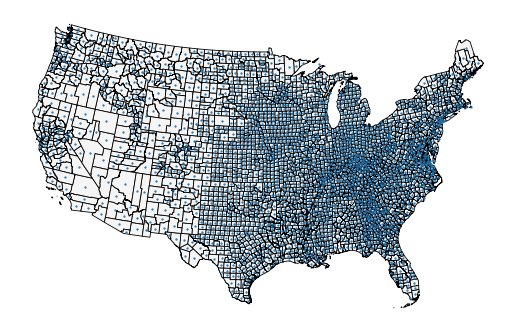

In [34]:
fig, ax = plt.subplots()
county_gpd = county_gpd.to_crs("ESRI:102003")
county_gpd.plot(ax=ax, color='whitesmoke', edgecolor='black', linewidth=0.6).set_axis_off()
county_gpd.centroid.plot(ax=ax, marker='o', markersize=0.4, zorder=3)
plt.show()